In [115]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline


# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')


In [116]:

# 2. Load the dataset

train = pd.read_csv("Train Dataset .csv")
test = pd.read_csv("Test Dataset.csv")
var = pd.read_csv("Variable_Definitions.csv") 
submission = pd.read_csv("Sample Submission.csv")

# Rename the columns in the DataFrame
test.rename(columns={'id': 'Id', 'age': 'Age', 'sex': 'Sex'}, inplace=True)

#concatenating the train and test dataframe
train["targ"] = "train"
test["targ"] = "test"

df= pd.concat([train, test], ignore_index=True)
df.shape

(10000, 16)

In [117]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        10000 non-null  int64  
 1   Age       10000 non-null  int64  
 2   Sex       10000 non-null  int64  
 3   cp        10000 non-null  int64  
 4   trestbps  10000 non-null  int64  
 5   chol      10000 non-null  int64  
 6   fbs       10000 non-null  int64  
 7   restecg   10000 non-null  int64  
 8   thalach   10000 non-null  int64  
 9   exang     10000 non-null  int64  
 10  oldpeak   10000 non-null  float64
 11  slope     10000 non-null  int64  
 12  ca        10000 non-null  int64  
 13  thal      10000 non-null  int64  
 14  target    7303 non-null   float64
 15  targ      10000 non-null  object 
dtypes: float64(2), int64(13), object(1)
memory usage: 1.2+ MB


In [118]:
# Display basic information
print("Dataset Shape:", df.shape)
print("Missing Values:\n", df.isnull().sum())
print("Target Distribution:\n", df['target'].value_counts())

Dataset Shape: (10000, 16)
Missing Values:
 Id             0
Age            0
Sex            0
cp             0
trestbps       0
chol           0
fbs            0
restecg        0
thalach        0
exang          0
oldpeak        0
slope          0
ca             0
thal           0
target      2697
targ           0
dtype: int64
Target Distribution:
 target
1.0    5941
0.0    1362
Name: count, dtype: int64


In [119]:
df['Sex'] = df['Sex'].map({0: 'Female', 1: 'Male'})
df['cp'] = df['cp'].map({0: 'Typical Angina', 1: 'Atypical Angina', 2: 'Non-Anginal Pain', 3: 'Asymptomatic'})
df['fbs'] = df['fbs'].map({0: 'FBS <= 120 mg/dl', 1: 'FBS > 120 mg/dl'})
df['exang'] = df['exang'].map({0: 'No', 1: 'Yes'})


In [120]:
df.head()

,Id,Age,Sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,targ
0,16167,33,Female,Atypical Angina,158,205,FBS > 120 mg/dl,0,154,No,1.5,1,4,1,1.0,train
1,11275,53,Male,Non-Anginal Pain,198,154,FBS <= 120 mg/dl,1,104,No,0.8,2,1,0,0.0,train
2,13251,37,Male,Non-Anginal Pain,101,202,FBS > 120 mg/dl,0,155,No,2.1,1,3,1,1.0,train
3,19921,75,Female,Typical Angina,113,306,FBS > 120 mg/dl,2,88,Yes,4.9,0,2,2,1.0,train
4,11293,35,Male,Non-Anginal Pain,139,419,FBS > 120 mg/dl,1,166,Yes,0.9,2,4,0,1.0,train


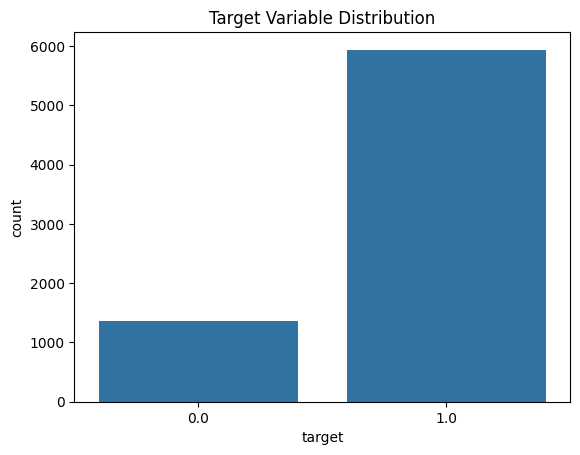

In [121]:
# Visualize Target Distribution
sns.countplot(x='target', data=df)
plt.title('Target Variable Distribution')
plt.show()


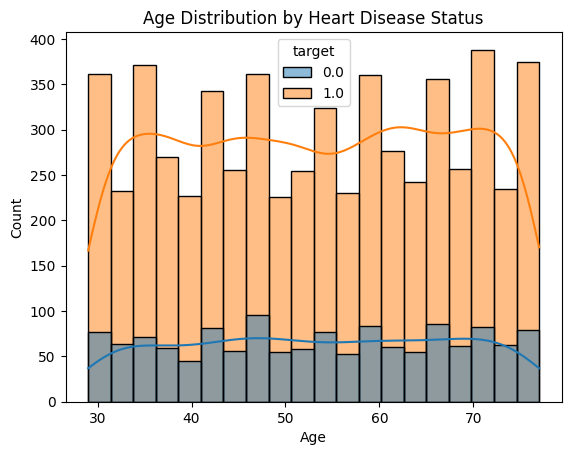

In [122]:
# 4.2 Age Distribution by Heart Disease Status
sns.histplot(data=df, x='Age', hue='target', kde=True)
plt.title('Age Distribution by Heart Disease Status')
plt.show()

In [95]:
# 5. Preprocessing Pipeline
# Identify numerical and categorical columns
numeric_features = ['Age', 'trestbps', 'chol', 'restecg', 'slope', 'thalach', 'oldpeak', 'ca', 'thal']
categorical_features = ['Sex', 'cp', 'fbs', 'exang']

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        10000 non-null  int64  
 1   Age       10000 non-null  int64  
 2   Sex       10000 non-null  object 
 3   cp        10000 non-null  object 
 4   trestbps  10000 non-null  int64  
 5   chol      10000 non-null  int64  
 6   fbs       10000 non-null  object 
 7   restecg   10000 non-null  int64  
 8   thalach   10000 non-null  int64  
 9   exang     10000 non-null  object 
 10  oldpeak   10000 non-null  float64
 11  slope     10000 non-null  int64  
 12  ca        10000 non-null  int64  
 13  thal      10000 non-null  int64  
 14  target    7303 non-null   float64
 15  targ      10000 non-null  object 
dtypes: float64(2), int64(9), object(5)
memory usage: 1.2+ MB


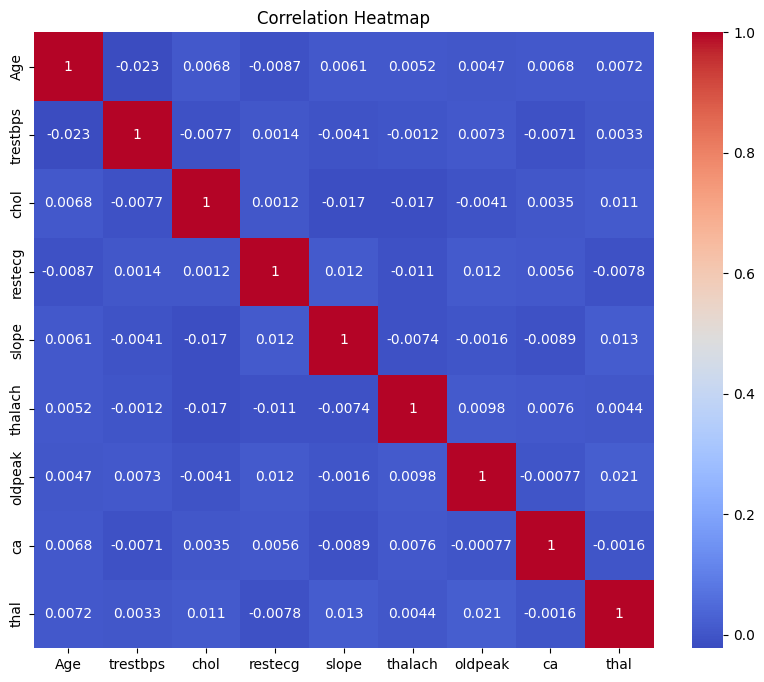

In [98]:
# 4.3 Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [99]:
train_data = df[df["targ"] == "train"].drop(["targ", "Id"], axis=1)
test_data = df[df["targ"] == "test"].drop(["targ", "target", "Id"], axis=1)

In [101]:
# 3. Define Features and Target
X = train_data.drop('target', axis=1)
y = train_data['target']

# 4. Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [102]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7303 entries, 0 to 7302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       7303 non-null   int64  
 1   Sex       7303 non-null   object 
 2   cp        7303 non-null   object 
 3   trestbps  7303 non-null   int64  
 4   chol      7303 non-null   int64  
 5   fbs       7303 non-null   object 
 6   restecg   7303 non-null   int64  
 7   thalach   7303 non-null   int64  
 8   exang     7303 non-null   object 
 9   oldpeak   7303 non-null   float64
 10  slope     7303 non-null   int64  
 11  ca        7303 non-null   int64  
 12  thal      7303 non-null   int64  
 13  target    7303 non-null   float64
dtypes: float64(2), int64(8), object(4)
memory usage: 855.8+ KB


In [103]:
train_data.head()

,Age,Sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,33,Female,Atypical Angina,158,205,FBS > 120 mg/dl,0,154,No,1.5,1,4,1,1.0
1,53,Male,Non-Anginal Pain,198,154,FBS <= 120 mg/dl,1,104,No,0.8,2,1,0,0.0
2,37,Male,Non-Anginal Pain,101,202,FBS > 120 mg/dl,0,155,No,2.1,1,3,1,1.0
3,75,Female,Typical Angina,113,306,FBS > 120 mg/dl,2,88,Yes,4.9,0,2,2,1.0
4,35,Male,Non-Anginal Pain,139,419,FBS > 120 mg/dl,1,166,Yes,0.9,2,4,0,1.0


In [104]:
# Preprocessing for Numerical Data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for Categorical Data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine Preprocessing Steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [105]:
# 6. Handling Imbalanced Data with SMOTETomek
# SMOTETomek combines oversampling with SMOTE and undersampling with Tomek links
resampler = SMOTETomek(random_state=42)

In [106]:
# 7. Model Pipelines using imblearn's Pipeline
rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', resampler),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', resampler),
    ('classifier', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1))
])

lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', resampler),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

In [107]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5842, 13), (5842,), (1461, 13), (1461,))

In [108]:
X_train

,Age,Sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
5131,32,Female,Non-Anginal Pain,194,504,FBS > 120 mg/dl,1,76,No,3.1,1,2,1
2350,61,Female,Non-Anginal Pain,148,502,FBS <= 120 mg/dl,0,119,No,0.8,0,4,3
6276,30,Female,Non-Anginal Pain,101,403,FBS > 120 mg/dl,1,127,No,3.4,1,1,2
963,75,Male,Typical Angina,147,541,FBS > 120 mg/dl,1,78,No,5.8,1,3,0
1755,45,Male,Atypical Angina,152,427,FBS <= 120 mg/dl,2,175,Yes,2.9,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,33,Female,Atypical Angina,131,386,FBS <= 120 mg/dl,1,78,No,0.1,1,4,2
4368,36,Male,Typical Angina,144,208,FBS > 120 mg/dl,2,88,Yes,5.0,1,1,3
7289,70,Male,Asymptomatic,145,540,FBS <= 120 mg/dl,2,88,Yes,2.7,0,0,0
5882,70,Male,Typical Angina,191,256,FBS <= 120 mg/dl,1,120,No,0.9,0,4,3


In [109]:
# 8. Hyperparameter Tuning with GridSearchCV
# Example: Hyperparameter tuning for RandomForest
rf_param_grid = {
    'classifier__n_estimators': [100, 500, 1000],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2]
}
# Initialize GridSearchCV
rf_grid_search = RandomizedSearchCV(rf_pipeline, rf_param_grid, cv=StratifiedKFold(n_splits=10), scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit GridSearch on Training Data
rf_grid_search.fit(X_train, y_train)

# Best Parameters and Score
print("Best Parameters for RandomForest:", rf_grid_search.best_params_)
print("Best ROC-AUC Score for RandomForest:", rf_grid_search.best_score_)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters for RandomForest: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}
Best ROC-AUC Score for RandomForest: 0.8823273131560689


In [110]:

# 9. Evaluate Models
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    print(f"\n=== {model_name} Evaluation ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label=f'{model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')
    plt.show()


=== Random Forest Evaluation ===
Confusion Matrix:
 [[266   6]
 [260 929]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.98      0.67       272
         1.0       0.99      0.78      0.87      1189

    accuracy                           0.82      1461
   macro avg       0.75      0.88      0.77      1461
weighted avg       0.90      0.82      0.84      1461

ROC-AUC Score: 0.8923990748528174


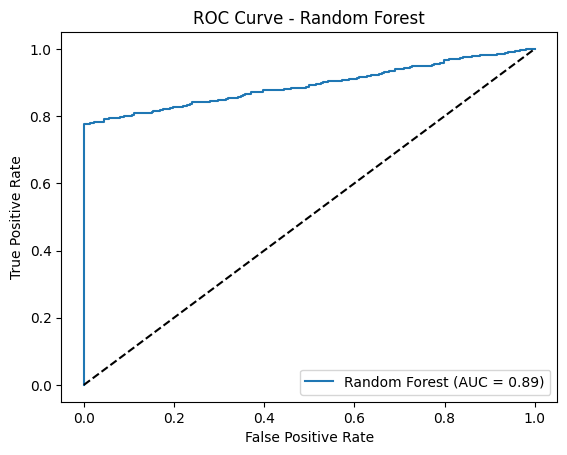

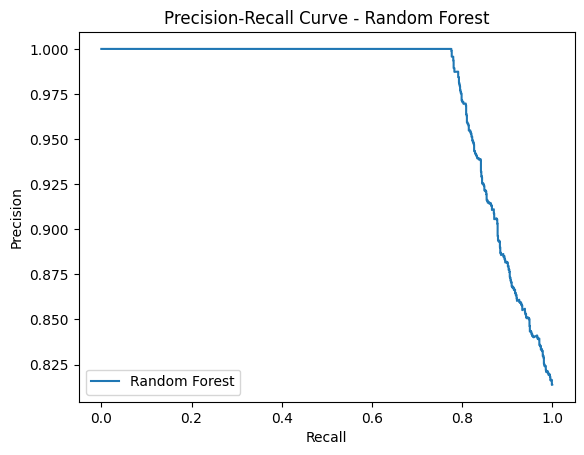

In [111]:

# Evaluate RandomForest
best_rf = rf_grid_search.best_estimator_
evaluate_model(best_rf, X_test, y_test, "Random Forest")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters for XGBoost: {'classifier__subsample': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Best ROC-AUC Score for XGBoost: 0.8832734500850075

=== XGBoost Evaluation ===
Confusion Matrix:
 [[272   0]
 [269 920]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       272
         1.0       1.00      0.77      0.87      1189

    accuracy                           0.82      1461
   macro avg       0.75      0.89      0.77      1461
weighted avg       0.91      0.82      0.83      1461

ROC-AUC Score: 0.8849379112452382


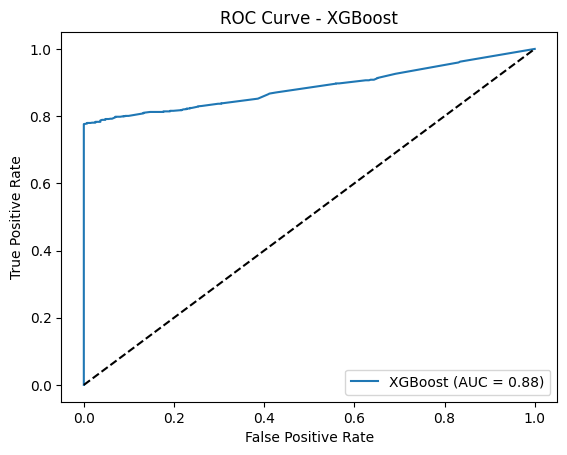

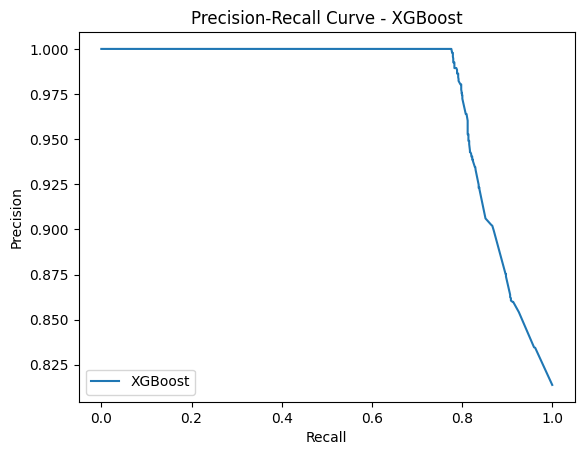

In [114]:

# Similarly, perform GridSearch and Evaluation for XGBoost and Logistic Regression
# Example: Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'classifier__n_estimators': [100, 500, 1000],
    'classifier__max_depth': [3, 5, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 1.0]
}

xgb_grid_search = RandomizedSearchCV(xgb_pipeline, xgb_param_grid, cv=StratifiedKFold(n_splits=10), scoring='roc_auc', n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)

print("Best Parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best ROC-AUC Score for XGBoost:", xgb_grid_search.best_score_)

# Evaluate XGBoost
best_xgb = xgb_grid_search.best_estimator_
evaluate_model(best_xgb, X_test, y_test, "XGBoost")

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Parameters for Logistic Regression: {'classifier__solver': 'lbfgs', 'classifier__C': 0.01}
Best ROC-AUC Score for Logistic Regression: 0.8779465122601431

=== Logistic Regression Evaluation ===
Confusion Matrix:
 [[272   0]
 [269 920]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       272
         1.0       1.00      0.77      0.87      1189

    accuracy                           0.82      1461
   macro avg       0.75      0.89      0.77      1461
weighted avg       0.91      0.82      0.83      1461

ROC-AUC Score: 0.8808842081828525


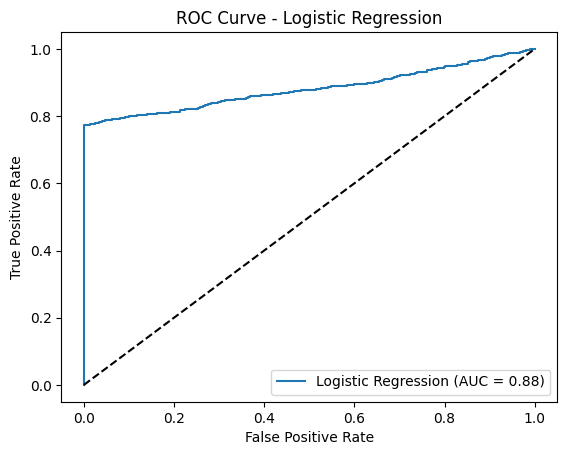

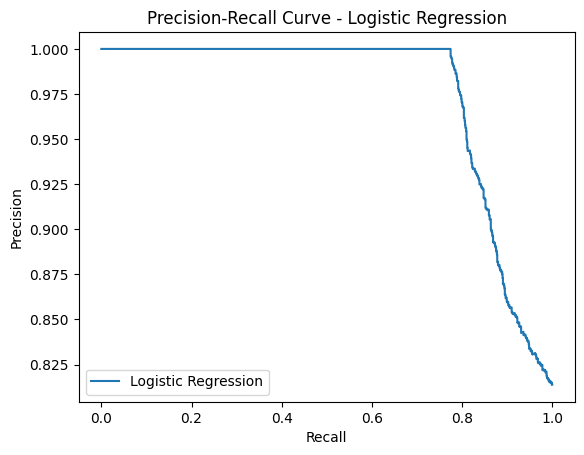

In [21]:
# Example: Hyperparameter tuning for Logistic Regression
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

lr_grid_search = RandomizedSearchCV(lr_pipeline, lr_param_grid, cv=StratifiedKFold(n_splits=10), scoring='roc_auc', n_jobs=-1, verbose=2)
lr_grid_search.fit(X_train, y_train)

print("Best Parameters for Logistic Regression:", lr_grid_search.best_params_)
print("Best ROC-AUC Score for Logistic Regression:", lr_grid_search.best_score_)

# Evaluate Logistic Regression
best_lr = lr_grid_search.best_estimator_
evaluate_model(best_lr, X_test, y_test, "Logistic Regression")


=== Ensemble Voting Classifier Evaluation ===
Confusion Matrix:
 [[272   0]
 [269 920]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       272
         1.0       1.00      0.77      0.87      1189

    accuracy                           0.82      1461
   macro avg       0.75      0.89      0.77      1461
weighted avg       0.91      0.82      0.83      1461

ROC-AUC Score: 0.8873188047296294


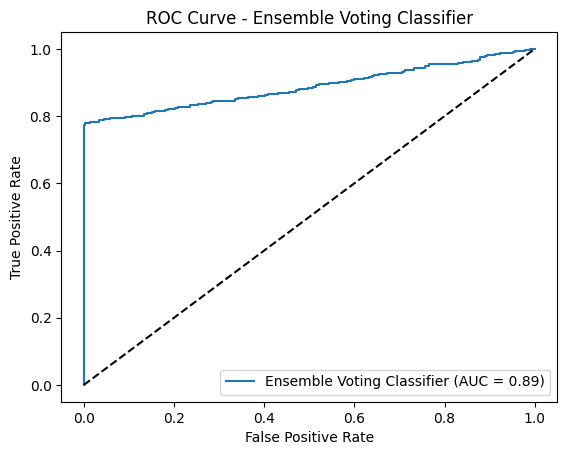

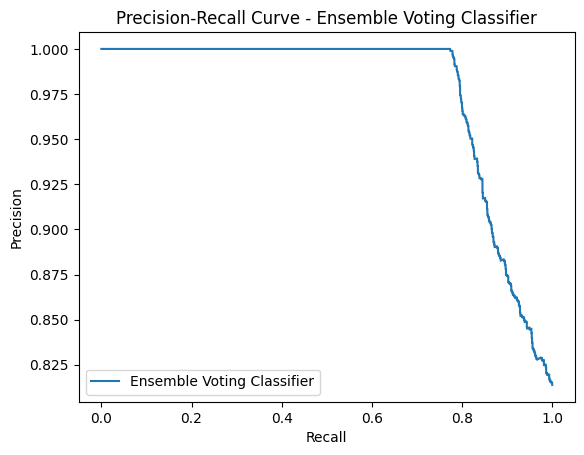

In [22]:

# 10. Model Stacking (Ensemble)
# Using Voting Classifier to combine models
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lr', best_lr)
], voting='soft', weights=[2, 3, 1], n_jobs=-1)

# Fit Voting Classifier
voting_clf.fit(X_train, y_train)

# Evaluate Ensemble Model
evaluate_model(voting_clf, X_test, y_test, "Ensemble Voting Classifier")

In [24]:
# import shap
# # 10. Model Interpretation using SHAP for XGBoost
# explainer = shap.Explainer(best_xgb.named_steps['classifier'])
# shap_values = explainer(X_test)

# # Plot SHAP summary
# shap.summary_plot(shap_values, X_test)



In [112]:
# 6.3 Predicting and Creating the Submission File
test_pred = best_rf.predict(test_data)
test_pred = test_pred.astype(int)

In [113]:

submission = pd.DataFrame({'Id': submission['Id'], 'target': test_pred})
submission.to_csv('sub1_rf.csv', index=False)

print("Submission file created: 'submission.csv'")

Submission file created: 'submission.csv'
